# Wrangling + Tf-Idf model

In [2]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [64]:
data = pd.read_csv("clean_data.csv") # json new way

Look at the data:

In [65]:
print(data.describe(include="object"))

        title   identifier                                        description  \
count    3924         3924                                               3924   
unique   3505         3924                                               3642   
top     Dance  AMST-103-HM  Individual Instruction, Level II. Initial enro...   
freq        8            1                                                 37   

        source instructors         offered prerequisites corequisites  \
count     3924        3924            2616           954           32   
unique       5        1190             133           621           27   
top     Pomona          []  Each semester.   PSYC 051 PO  BIOL052 HM    
freq      1299        1683             383            16            2   

       department  
count        3924  
unique        100  
top          HIST  
freq          274  


### Tf-Idf with scikit-learn
[Description](https://monkeylearn.com/blog/what-is-tf-idf/)

[Usage](https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Y1M42ezMJhF)

Here is an example of how Tf-Idf would work if our documents were the following 4 sentences:

In [34]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

corpus = [
     'this is the first document',
     'this document is the second document',
     'and this is the third one',
     'is this the first document',
     "1999"
]
vectorizer = TfidfVectorizer(use_idf=True)
vectors = vectorizer.fit_transform(corpus)
firstv = vectors[0]
index=vectorizer.get_feature_names().index("first")
print(firstv.T.todense()[index].item())
df = pd.DataFrame(firstv.T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"])
df = df.sort_values(by=["tfidf"], ascending = False)
print("TfIdf values for the first sentence")
print(df)


0.5519024203973655
TfIdf values for the first sentence
             tfidf
first     0.551902
document  0.465954
is        0.399287
the       0.399287
this      0.399287
00        0.000000
1999      0.000000
and       0.000000
one       0.000000
second    0.000000
third     0.000000


In the example above we can see the importance of each word ranked for the first sentence `'this is the first document'`. So, for example the word `first` is important since it doesn't appear in any other document. The word `the` is not as important since it appears in all other documents. And the word `third` is not important at all since it doesn't even appear in the first document.

### Rank classes based on a given word
Function `tfidf_word(word, data)` takes in the word we are interested in and the data we are looking at. The function returns an updated dataframe with a new column `"score"` that gives each class a score of importance based on the input word. 

In [66]:
def tfidf_word(word, data_1):
    data_2 = data_1.copy() # since we don't want to be making changes to our original dataframe
    corpus = list(data_2.description)
    vectorizer = TfidfVectorizer(use_idf=True, stop_words='english')
    vectors = vectorizer.fit_transform(corpus)

    score_for_word = []
    words = vectorizer.get_feature_names()
    try:
        index = words.index(word)
    except:
        print("'" + word + "'" + " is not mentioned in any course descriptions")
        return

    for i in range(0, len(corpus)):
        value = vectors[i].T.todense()[index]
        score_for_word.append(value)

    score_for_word = [float(i) for i in score_for_word] # type cast each score to a float

    data_2["score"] = score_for_word
    return data_2

For example, let's say we are interested in ranking all of the classes based on the word `computer`:

In [67]:
tfidf_word('computer', data).sort_values(by=["score"], ascending = False).head(5)

,Unnamed: 0,title,identifier,description,source,credits,instructors,offered,prerequisites,corequisites,currently_offered,fee,department,score
127,132,Computer Science Seminar,CSCI-181-HM,Advanced topics of current interest in compute...,HarveyMudd,0,['Staff'],Fall and Spring,Permission of instructor,NaN,False,0,CSCI,0.517196
506,525,Special Topics in Computer Science,CSCI-181-CM,Selected topics in computer science. May be re...,ClaremontMckenna,100,[],Occasionally,NaN,NaN,False,0,CSCI,0.481765
1420,1485,Computer Science Colloquium,CSCI-188-PO,Colloquium presentations and discussions of to...,Pomona,0,['Joseph C Osborn'],Each semester.,"CSCI 051A PO , or CSCI 051G PO , or CSCI 051J ...",NaN,True,0,CSCI,0.429991
417,426,Introduction to Computational Neuroscience,BIOL-133L-KS,This course provides computational skills for ...,ClaremontMckenna,100,[],Every fall,NaN,NaN,False,0,BIOL,0.365221
1030,1059,Computational Physics and Engineering,PHYS-100-KS,This course is a comprehensive introduction to...,ClaremontMckenna,100,['Scot Gould'],Every spring,NaN,NaN,True,0,PHYS,0.343432


These are the first 10 instances of the classes that are most related to the word `computer` ranked in descending order (more related classes are on top). So, we could recomend a student who is interested in `computer`
 to take these classes.

Bellow are the outputs for fords `data, culture, activism, fiction, environment`

In [9]:
tfidf_word('environment', data).sort_values(by=["score"], ascending = False).head(5)

,Unnamed: 0,title,identifier,description,source,credits,instructors,offered,prerequisites,corequisites,currently_offered,fee,department,score
1707,1790,Food and the Environment in Asia and the Pacific,HIST-101F-PO,A single question inspired this seminar: what ...,Pomona,100,['S. Yamashita'],Last offered spring 2018.,NaN,NaN,False,0,HIST,0.402584
1017,1046,Environmental Ethics,PHIL-187-CM,An exploration of human beings’ ethical relati...,ClaremontMckenna,100,[],Occasionally,NaN,NaN,False,0,PHIL,0.302278
447,456,Microbiology,BIOL-168L-KS,In this fundamental microbiology course we wil...,ClaremontMckenna,100,['Pete Chandrangsu'],Occasionally,NaN,NaN,True,0,BIOL,0.291911
3456,3665,Critical Environmental Analysis,EA-150-PZ,A seminar examination of how environmental iss...,Pitzer,0,[],NaN,NaN,NaN,False,0,EA,0.263878
2384,2530,"Africa, the Environment, and the Global Economy",SOC-189H-PO,"Drawing on sociology and related disciplines, ...",Pomona,100,['S. Stefanos'],Each fall.,NaN,NaN,False,0,SOC,0.238709


# Cosine Similarities

In [10]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
def cos_sim(data, id, penalty=1.0):
    corpus = list(data.description)
    vectorizer = TfidfVectorizer(use_idf=True, stop_words='english')
    vectors = vectorizer.fit_transform(corpus)
    cosine_sim = linear_kernel(vectors, vectors)

    index_id = list(data.index[data["identifier"] == id]) # indexes of input classes
    if len(index_id) == 0:
        print("Couldn't find courses")
        return
    else:
        index_id = index_id[0]
    
    data_out = data.copy()
    data_out["score"] = cosine_sim[index_id]

    if penalty!=1.0:
        department = id[:id.index("-")]
        print("penalizing " + department +" courses by a factor of " + str(penalty))
        
        for index in data_out.index:
            if data_out["identifier"][index] == id:
                data_out["score"][index] = 0.0
            elif department in data_out["identifier"][index]:
                data_out["score"][index] = data_out["score"][index]*penalty
    else:
        print("No penalty")

    return data_out




In [11]:
cos_sim(data, "AMST-120-HM").sort_values(by=["score"], ascending = False).head(5)

No penalty


,Unnamed: 0,title,identifier,description,source,credits,instructors,offered,prerequisites,corequisites,currently_offered,fee,department,score
2,2,Hyphenated Americans,AMST-120-HM,A focus on the experience of immigrants in the...,HarveyMudd,300,['Balseiro'],NaN,NaN,NaN,False,0,AMST,1.000000
3037,3228,Marginalized Communities,POLI-155-SC,"This course explores definitions, mechanisms, ...",Scripps,0,[],NaN,NaN,NaN,False,0,POLI,0.185190
293,300,Music in the United States,MUS-118-SC,A survey of the history and development of mus...,Scripps,100,['Charles W. Kamm'],NaN,NaN,NaN,True,0,MUS,0.178889
14,14,Introduction to Asian American History: 1850-P...,ASAM-125-AA,This survey course examines the history of Asi...,HarveyMudd,300,['Flores'],NaN,NaN,NaN,False,0,ASAM,0.173398
2809,2984,African Diaspora in the United States to 1877,HIST-050A-AF,This course examines the diverse and complex e...,Scripps,100,[],NaN,NaN,NaN,False,0,HIST,0.166455


In [12]:
cos_sim(data, "CSCI-036-CM").sort_values(by=["score"], ascending = False).head(5)

No penalty


,Unnamed: 0,title,identifier,description,source,credits,instructors,offered,prerequisites,corequisites,currently_offered,fee,department,score
494,513,Foundations of Data Science,CSCI-036-CM,Data science is the interdisciplinary study of...,ClaremontMckenna,100,['Sarah Cannon'],Every year,NaN,NaN,True,0,CSCI,1.000000
3099,3292,Data Science Ethics and Justice,PSYC-183-SC,Data science is a set of interdisciplinary app...,Scripps,100,['Michael L. Spezio'],Every spring,NaN,NaN,True,0,PSYC,0.322159
507,526,Advanced Projects in Data Science,DS-180-CM,This course allows teams of students to wrestl...,ClaremontMckenna,100,['Jeho Park'],Every year,NaN,NaN,True,0,DS,0.313127
1310,1361,Data Analysis and Programming for the Life Sci...,BIOL-174-PO,This course explores the analysis of big data ...,Pomona,100,['Andre Cavalcanti'],Last offered spring 2019.,BIOL 040 PO and one of the following CSCI 005 ...,NaN,True,0,BIOL,0.276039
2917,3100,CS1: Intro to Python and Viz,MS-059-SC,This is an introduction to computer programmin...,Scripps,0,[],NaN,NaN,NaN,False,0,MS,0.256833


In [13]:
cos_sim(data, "CSCI-036-CM", penalty=0.5).sort_values(by=["score"], ascending = False).head(5)

penalizing CSCI courses by a factor of 0.5


,Unnamed: 0,title,identifier,description,source,credits,instructors,offered,prerequisites,corequisites,currently_offered,fee,department,score
3099,3292,Data Science Ethics and Justice,PSYC-183-SC,Data science is a set of interdisciplinary app...,Scripps,100,['Michael L. Spezio'],Every spring,NaN,NaN,True,0,PSYC,0.322159
507,526,Advanced Projects in Data Science,DS-180-CM,This course allows teams of students to wrestl...,ClaremontMckenna,100,['Jeho Park'],Every year,NaN,NaN,True,0,DS,0.313127
1310,1361,Data Analysis and Programming for the Life Sci...,BIOL-174-PO,This course explores the analysis of big data ...,Pomona,100,['Andre Cavalcanti'],Last offered spring 2019.,BIOL 040 PO and one of the following CSCI 005 ...,NaN,True,0,BIOL,0.276039
2917,3100,CS1: Intro to Python and Viz,MS-059-SC,This is an introduction to computer programmin...,Scripps,0,[],NaN,NaN,NaN,False,0,MS,0.256833
944,968,Introduction to Data Mining,MATH-166-CM,Data mining is the process of discovering patt...,ClaremontMckenna,100,[],Every year,NaN,NaN,False,0,MATH,0.243888


## Cosine Similarities for the list of classes

In [14]:
def cos_sim_list(data, ids, penalty=1.0):
    out = []
    for id in ids:
        out.append(list(cos_sim(data, id, penalty).sort_values(by=["score"], ascending = False).head(5).identifier))

    flat = []
    for i in range(len(out[0])):
        for j in out:
            flat.append(j[i])
    return flat

In [15]:
cos_sim_list(data,["CSCI-036-CM", "AMST-120-HM", "LIT-138-CM"], penalty=0.5)

penalizing CSCI courses by a factor of 0.5
penalizing AMST courses by a factor of 0.5
penalizing LIT courses by a factor of 0.5


['PSYC-183-SC',
 'POLI-155-SC',
 'MS-172-HM',
 'DS-180-CM',
 'MUS-118-SC',
 'MUS-067-HM',
 'BIOL-174-PO',
 'ASAM-125-AA',
 'MS-114-PZ',
 'MS-059-SC',
 'HIST-050A-AF',
 'HIST-139E-CM',
 'MATH-166-CM',
 'CHST-028-CH',
 'ANTH-189P-PO']

# Tasks:
- come up with the validation data set
- visit pomonastudents.org
- Look at Glove

The following code writes a csv file of nodes and scores between them for our graph

In [17]:
import csv
node_data = data
def build_nodes():
    corpus = list(node_data.description)
    vectorizer = TfidfVectorizer(use_idf=True, stop_words='english')
    vectors = vectorizer.fit_transform(corpus)
    cosine_sim = linear_kernel(vectors, vectors)
    cosine_sim = cosine_sim.round(4)
    length = len(cosine_sim)
    out = []
    for i in range(length):
        for j in range(i+1, length):
            #node1 = node_data.loc[i, "identifier"]
            #node2 = node_data.loc[j, "identifier"]
            score = cosine_sim[i][j]
            if score < 0.1:
                score = 0.0
            out.append([i, j, score])
            #if score>= 0.1:
                #out.append([i, j, score])

    with open("nodes.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["node1", "node2", "score"])
        writer.writerows(out)
        

#build_nodes()

,node1,node2,score
408,12,2494,0.2999
22892,577,702,0.2999
54225,1425,1428,0.2999
63916,1741,1951,0.2999


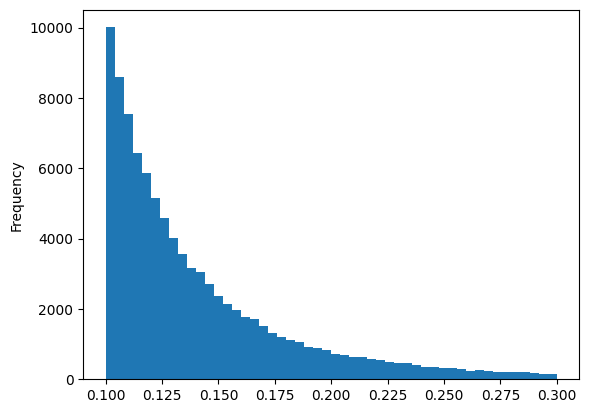

In [18]:
dense_nodes = pd.read_csv("dense_nodes.csv")
dense_nodes = dense_nodes[dense_nodes['score'] < 0.3]
dense_nodes.score.plot.hist(bins=50)

dense_nodes[dense_nodes.score == dense_nodes.score.max()]